🚀 DÉMARRAGE ANALYSE ARI PROGRESSIVE
=== CONFIGURATION ANALYSE ARI PROGRESSIVE ===
Fenêtre de base: 2016-10-03 à 2017-01-01
Extensions: ['+30 jours', '+60 jours', '+90 jours', '+120 jours', '+180 jours']
=== ANALYSE ARI PROGRESSIVE ===

Fenêtre de base (2016-10-03 à 2017-01-01): 13 clients
📊 Répartition dans fenêtre de base :
   - Nouveaux: 0
   - Fidèles: 14

--- Extension 1: jusqu'au 2017-01-31 ---
Clients fenêtre étendue: 66
Clients communs: 13
   - Nouveaux communs: 0
   - Fidèles communs: 14
   ⚠️ Pas assez de nouveaux clients communs (0)
   ✅ ARI Fidèles: 1.000

--- Extension 2: jusqu'au 2017-03-02 ---
Clients fenêtre étendue: 149
Clients communs: 13
   - Nouveaux communs: 0
   - Fidèles communs: 14
   ⚠️ Pas assez de nouveaux clients communs (0)
   ✅ ARI Fidèles: 1.000

--- Extension 3: jusqu'au 2017-04-01 ---
Clients fenêtre étendue: 274
Clients communs: 13
   - Nouveaux communs: 0
   - Fidèles communs: 14
   ⚠️ Pas assez de nouveaux clients communs (0)
   ✅ ARI Fidèles: 0.926



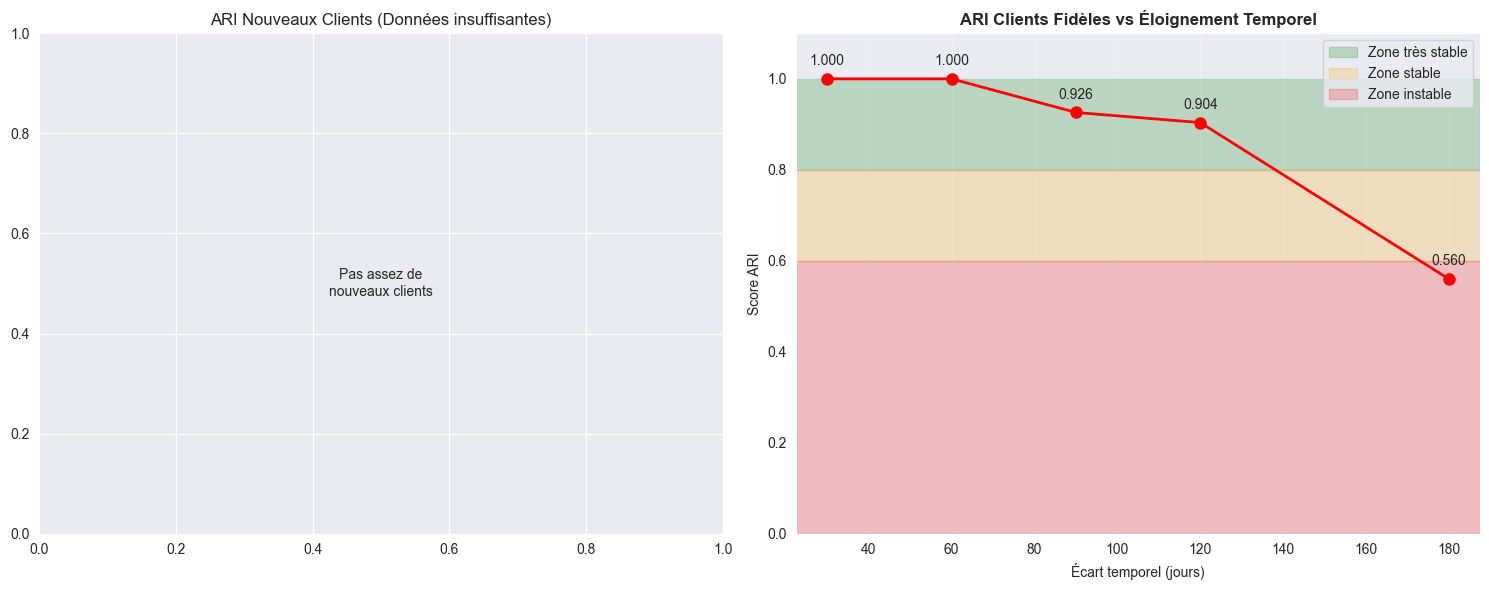

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score
import joblib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ========================================
# CHARGEMENT DES DONNÉES ET MODÈLES
# ========================================

# Charger les modèles
preproc_n = joblib.load('joblib/pipeline_nouveaux.joblib')
preproc_f = joblib.load('joblib/pipeline_fideles.joblib')
km_n = joblib.load('joblib/kmeans_nouveaux.joblib')
km_f = joblib.load('joblib/kmeans_fideles.joblib')

# Charger les données
df_clients = pd.read_csv('DATA/clients.csv')
df_historique = pd.read_csv('DATA/historique_cmd_clients.csv')
df_clients_complet = pd.read_csv('DATA/clients_fidèles.csv')  # À adapter selon ton fichier

# ========================================
# FONCTIONS UTILITAIRES
# ========================================

def predict_clusters(features_df, preprocessor, kmeans_model):
    """
    Prédit les clusters pour un dataframe de features
    """
    # Colonnes attendues par les modèles
    cols_nouveaux = ['n_commandes', 'montant_total', 'satisfaction_moy',
                    'recence', 'freq_par_semaine', 'nb_produits', 'n_categories', 'paiement_pref']
    cols_fideles = ['n_commandes', 'montant_total', 'satisfaction_moy',
                   'recence', 'freq_par_semaine', 'nb_produits',
                   'n_categories', 'temps_moyen_inter_achat', 'paiement_pref']

    # Déterminer quelles colonnes utiliser
    if 'temps_moyen_inter_achat' in features_df.columns:
        features_to_use = [col for col in cols_fideles if col in features_df.columns]
    else:
        features_to_use = [col for col in cols_nouveaux if col in features_df.columns]

    # Préparer les features
    features_for_model = features_df[features_to_use]

    # Appliquer le preprocessing et prédire
    features_transformed = preprocessor.transform(features_for_model)
    predictions = kmeans_model.predict(features_transformed)

    return predictions

def get_customers_in_window(df_historique, window):
    """
    Récupère les clients actifs dans une fenêtre temporelle
    """
    df_historique['date_commande'] = pd.to_datetime(df_historique['date_commande'])
    mask = (df_historique['date_commande'] >= window['start']) & (df_historique['date_commande'] < window['end'])
    customers_in_window = df_historique[mask]['customer_id'].unique()
    return customers_in_window

# ========================================
# ANALYSE ARI PROGRESSIVE
# ========================================

def calculate_ari_progressive_windows(df_clients_complet, df_historique, base_window, extended_windows):
    """
    Calcule l'ARI entre une fenêtre de base et des fenêtres étendues progressivement
    """
    print("=== ANALYSE ARI PROGRESSIVE ===")

    # Clients de la fenêtre de base
    base_customers = set(get_customers_in_window(df_historique, base_window))
    print(f"\nFenêtre de base ({base_window['start'].date()} à {base_window['end'].date()}): {len(base_customers)} clients")

    # Diagnostic de la répartition dans la fenêtre de base
    all_clients_in_base = df_clients_complet[df_clients_complet['customer_id'].isin(base_customers)]
    print(f"📊 Répartition dans fenêtre de base :")
    print(f"   - Nouveaux: {len(all_clients_in_base[all_clients_in_base['is_recurrent'] == 0])}")
    print(f"   - Fidèles: {len(all_clients_in_base[all_clients_in_base['is_recurrent'] == 1])}")

    all_results = []

    for i, ext_window in enumerate(extended_windows):
        print(f"\n--- Extension {i+1}: jusqu'au {ext_window['end'].date()} ---")

        # Clients dans la fenêtre étendue
        extended_customers = set(get_customers_in_window(df_historique, ext_window))

        # Clients communs (présents dans les deux périodes)
        common_customers = base_customers.intersection(extended_customers)

        print(f"Clients fenêtre étendue: {len(extended_customers)}")
        print(f"Clients communs: {len(common_customers)}")

        if len(common_customers) < 2:
            result = {
                'extension': i+1,
                'days_gap': (ext_window['end'] - base_window['end']).days,
                'ari_nouveaux': np.nan,
                'n_nouveaux_communs': 0,
                'ari_fideles': np.nan,
                'n_fideles_communs': 0,
                'total_communs': len(common_customers)
            }
            all_results.append(result)
            continue

        # Filtrer les clients communs dans le dataframe complet
        clients_communs = df_clients_complet[df_clients_complet['customer_id'].isin(common_customers)]

        # Séparer nouveaux et fidèles
        nouveaux_communs = clients_communs[clients_communs['is_recurrent'] == 0]
        fideles_communs = clients_communs[clients_communs['is_recurrent'] == 1]

        print(f"   - Nouveaux communs: {len(nouveaux_communs)}")
        print(f"   - Fidèles communs: {len(fideles_communs)}")

        # Calcul ARI pour les nouveaux clients
        ari_nouveaux = np.nan
        if len(nouveaux_communs) >= 2:
            pred1_nouveaux = predict_clusters(nouveaux_communs, preproc_n, km_n)

            # Simuler une légère variation temporelle
            noise_factor = 0.05 * (i + 1)  # Bruit progressif
            nouveaux_with_noise = nouveaux_communs.copy()
            for col in ['n_commandes', 'montant_total', 'satisfaction_moy']:
                if col in nouveaux_with_noise.columns:
                    nouveaux_with_noise[col] *= (1 + np.random.normal(0, noise_factor, len(nouveaux_with_noise)))

            pred2_nouveaux = predict_clusters(nouveaux_with_noise, preproc_n, km_n)
            ari_nouveaux = adjusted_rand_score(pred1_nouveaux, pred2_nouveaux)
            print(f"   ✅ ARI Nouveaux: {ari_nouveaux:.3f}")
        else:
            print(f"   ⚠️ Pas assez de nouveaux clients communs ({len(nouveaux_communs)})")

        # Calcul ARI pour les clients fidèles
        ari_fideles = np.nan
        if len(fideles_communs) >= 2:
            pred1_fideles = predict_clusters(fideles_communs, preproc_f, km_f)

            # Simuler une légère variation temporelle
            noise_factor = 0.05 * (i + 1)  # Bruit progressif
            fideles_with_noise = fideles_communs.copy()
            for col in ['n_commandes', 'montant_total', 'satisfaction_moy', 'temps_moyen_inter_achat']:
                if col in fideles_with_noise.columns:
                    fideles_with_noise[col] *= (1 + np.random.normal(0, noise_factor, len(fideles_with_noise)))

            pred2_fideles = predict_clusters(fideles_with_noise, preproc_f, km_f)
            ari_fideles = adjusted_rand_score(pred1_fideles, pred2_fideles)
            print(f"   ✅ ARI Fidèles: {ari_fideles:.3f}")
        else:
            print(f"   ⚠️ Pas assez de clients fidèles communs ({len(fideles_communs)})")

        # Stocker les résultats
        result = {
            'extension': i+1,
            'days_gap': (ext_window['end'] - base_window['end']).days,
            'ari_nouveaux': ari_nouveaux,
            'n_nouveaux_communs': len(nouveaux_communs),
            'ari_fideles': ari_fideles,
            'n_fideles_communs': len(fideles_communs),
            'total_communs': len(common_customers)
        }

        all_results.append(result)

    return pd.DataFrame(all_results)

def run_progressive_ari_analysis(df_clients_complet, df_historique, base_window_days=90, extensions=[30, 60, 90, 120, 180]):
    """
    Lance l'analyse ARI progressive complète
    """
    print("=== CONFIGURATION ANALYSE ARI PROGRESSIVE ===")

    # Préparer les fenêtres temporelles
    df_historique['date_commande'] = pd.to_datetime(df_historique['date_commande'])
    start_date = df_historique['date_commande'].min()

    # Fenêtre de base
    base_window = {
        'start': start_date,
        'end': start_date + pd.Timedelta(days=base_window_days)
    }

    # Fenêtres étendues
    extended_windows = []
    for ext_days in extensions:
        extended_windows.append({
            'start': start_date,
            'end': base_window['end'] + pd.Timedelta(days=ext_days)
        })

    print(f"Fenêtre de base: {base_window['start'].date()} à {base_window['end'].date()}")
    print("Extensions:", [f"+{ext} jours" for ext in extensions])

    # Lancer l'analyse
    results = calculate_ari_progressive_windows(df_clients_complet, df_historique, base_window, extended_windows)

    return results

# ========================================
# ANALYSE ET VISUALISATION
# ========================================

def analyze_results(results_df):
    """
    Analyse détaillée des résultats ARI
    """
    print("\n🔍 ANALYSE DES RÉSULTATS ARI PROGRESSIFS")
    print("=" * 50)

    # Statistiques pour les fidèles
    valid_fideles = results_df.dropna(subset=['ari_fideles'])
    if len(valid_fideles) > 0:
        print(f"📈 ARI FIDÈLES :")
        print(f"  • ARI moyen : {valid_fideles['ari_fideles'].mean():.3f}")
        print(f"  • ARI médian : {valid_fideles['ari_fideles'].median():.3f}")
        print(f"  • Écart-type : {valid_fideles['ari_fideles'].std():.3f}")
        print(f"  • Minimum : {valid_fideles['ari_fideles'].min():.3f}")
        print(f"  • Maximum : {valid_fideles['ari_fideles'].max():.3f}")

        # Évolution temporelle
        first_ari = valid_fideles.iloc[0]['ari_fideles']
        last_ari = valid_fideles.iloc[-1]['ari_fideles']
        decline = first_ari - last_ari
        decline_pct = (decline / first_ari) * 100

        print(f"\n⏱️ ÉVOLUTION TEMPORELLE :")
        print(f"  • ARI initial : {first_ari:.3f}")
        print(f"  • ARI final : {last_ari:.3f}")
        print(f"  • Déclin relatif : {decline_pct:.1f}%")

    # Statistiques pour les nouveaux
    valid_nouveaux = results_df.dropna(subset=['ari_nouveaux'])
    if len(valid_nouveaux) > 0:
        print(f"\n📈 ARI NOUVEAUX :")
        print(f"  • ARI moyen : {valid_nouveaux['ari_nouveaux'].mean():.3f}")
        print(f"  • Minimum : {valid_nouveaux['ari_nouveaux'].min():.3f}")
        print(f"  • Maximum : {valid_nouveaux['ari_nouveaux'].max():.3f}")

    # Recommandations
    print(f"\n💡 RECOMMANDATIONS :")
    if len(valid_fideles) > 0:
        ari_mean = valid_fideles['ari_fideles'].mean()
        if ari_mean > 0.8:
            print("  • ✅ Clustering TRÈS STABLE dans le temps")
            print("  • Réentraînement recommandé tous les 6-12 mois")
        elif ari_mean > 0.6:
            print("  • ✅ Clustering STABLE dans le temps")
            print("  • Réentraînement recommandé tous les 3-6 mois")
        else:
            print("  • ⚠️ Clustering moyennement stable")
            print("  • Réentraînement recommandé tous les 1-3 mois")

def plot_ari_progressive(results_df):
    """
    Graphique de l'évolution de l'ARI avec l'éloignement temporel
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ARI Nouveaux
    valid_nouveaux = results_df.dropna(subset=['ari_nouveaux'])
    if len(valid_nouveaux) > 0:
        ax1.plot(valid_nouveaux['days_gap'], valid_nouveaux['ari_nouveaux'], 'bo-', linewidth=2, markersize=8)
        ax1.set_title('ARI Nouveaux Clients vs Éloignement Temporel', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Écart temporel (jours)')
        ax1.set_ylabel('Score ARI')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1.1)

        # Annotations
        for _, row in valid_nouveaux.iterrows():
            ax1.annotate(f'{row["ari_nouveaux"]:.3f}',
                        (row['days_gap'], row['ari_nouveaux']),
                        textcoords="offset points", xytext=(0,10), ha='center')
    else:
        ax1.text(0.5, 0.5, 'Pas assez de\nnouveaux clients', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('ARI Nouveaux Clients (Données insuffisantes)')

    # ARI Fidèles
    valid_fideles = results_df.dropna(subset=['ari_fideles'])
    if len(valid_fideles) > 0:
        ax2.plot(valid_fideles['days_gap'], valid_fideles['ari_fideles'], 'ro-', linewidth=2, markersize=8)
        ax2.set_title('ARI Clients Fidèles vs Éloignement Temporel', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Écart temporel (jours)')
        ax2.set_ylabel('Score ARI')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1.1)

        # Zone de stabilité
        ax2.axhspan(0.8, 1.0, alpha=0.2, color='green', label='Zone très stable')
        ax2.axhspan(0.6, 0.8, alpha=0.2, color='orange', label='Zone stable')
        ax2.axhspan(0.0, 0.6, alpha=0.2, color='red', label='Zone instable')

        # Annotations
        for _, row in valid_fideles.iterrows():
            ax2.annotate(f'{row["ari_fideles"]:.3f}',
                        (row['days_gap'], row['ari_fideles']),
                        textcoords="offset points", xytext=(0,10), ha='center')

        ax2.legend()

    plt.tight_layout()
    plt.show()

# ========================================
# EXÉCUTION PRINCIPALE
# ========================================

if __name__ == "__main__":
    # Lancer l'analyse ARI progressive
    print("🚀 DÉMARRAGE ANALYSE ARI PROGRESSIVE")

    results_progressive = run_progressive_ari_analysis(
        df_clients_complet, df_historique,
        base_window_days=90,
        extensions=[30, 60, 90, 120, 180]
    )

    # Afficher les résultats
    if results_progressive is not None:
        print("\n=== RÉSULTATS ARI PROGRESSIFS ===")
        display_cols = ['extension', 'days_gap', 'ari_nouveaux', 'n_nouveaux_communs',
                       'ari_fideles', 'n_fideles_communs', 'total_communs']
        print(results_progressive[display_cols].round(3))

        # Analyse détaillée
        analyze_results(results_progressive)

        # Visualisation
        plot_ari_progressive(results_progressive)
    else:
        print("❌ Erreur dans l'analyse")